In [3]:
# Data Analytics
import pandas as pd
import numpy as np

# Data Collection
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse

#Utils
import os
import time

# Data Visualisation
import matplotlib.pyplot as plt

#NLP - Modern
from sentence_transformers import SentenceTransformer
import bm25s
from wordcloud import WordCloud

#NLP - Classic
import re
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords


from nltk.tag import pos_tag


# ML/Vector Search
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

#Input/Query Validation
import base64
from pydantic import BaseModel, Field, ValidationError, field_validator

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading averaged_perceptron_tagger_eng: <urlopen
[nltk_data]     error [Errno 8] nodename nor servname provided, or not
[nltk_data]     known>


# Building GenAI applications using NLP

In this module, I'm going to go through how you can apply multiple NLP techniques as part of building a GenAI application. In this example, I'm going to

**Data Source**
Description                 |   Objective                           |   NLP
Collect webpage data        |   Guardrail: HTTPS, no redirect       |   Regex
Analyse Data                |   Understand content                  |   Bag of words, TD-IDF
Data Prep (Chunking)        |   Split into sentences                |   
Data Prep (Tokenisation)    |   Convert into words                  |
Feature Eng'g (Embedding)   |                                       |
Feature Eng'g (Indexing)    |   

**Keyword v. Semantic Retrieval**
Description                 |   Objective                           |   NLP
Semantic Retrieval          |   Similar chunks-to-query             |   KNN
Keyword Retrieval           |   Keyword/lexical chunks-to-query     |   TF-IDF, BM25

**User Query**
Description                 |   Objective                           |   NLP
User Query                  |   Guardrail: Prompt Attack            |   Regex
Query Decomposition         |   Improve search by retrieval method  |   POS/NER
 


### Data Collection

In GenAI Applications, data security is arguably the single largest risk to enterprise. Therefore, controlling data in/out of any AI/ML pipeline is critical for security, scalability, and performance. 

In [11]:
def valid_url(url):
    pattern = re.compile(
        # protocol + domain/subdomain + .com etc. + specific pages/paths
    r"^https?://[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(/[a-zA-Z0-9\-._~:/?#\[\]@!$&()*+,;=%]*)?$"
)
    if not pattern.fullmatch(url):
        return "Invalid URL address. Please try again"

    return True


In [13]:
def approved_url(url):

    approved_domains = {"calbears.com", "berkeley.edu"}
    disallowed_extensions = {".json", ".xml", ".csv", ".zip", ".exe", ".tar", ".gz"}

    parsed = urlparse(url)
    
    # 1. Enforce HTTPS
    if parsed.scheme != "https":
        return "Unsecure protocol. HTTPS only"
    
    # 2. Check approved domains
    hostname = parsed.hostname or ""
    domain_allowed = False

    for domain in approved_domains:
        if hostname == domain or hostname.endswith(f".{domain}"):
            domain_allowed = True
            break

    if not domain_allowed:
        return "This domain is not approved for data retrieval"

    # 3. Block disallowed file formats
    _, ext = os.path.splitext(parsed.path.lower())
    if ext in disallowed_extensions:
        return "This data format is not approved for data retrieval"

    return True



In [17]:
def webpage_to_df(url):
    # 1) Validate URL format and policy
    check_valid = valid_url(url)
    if check_valid is not True:
        return check_valid  

    check_approvals = approved_url(url)
    if check_approvals is not True:
        return check_approvals  

    # 2) Fetch Data
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/120.0.0.0 Safari/537.36"
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
    except requests.RequestException as e:
        return f"Failed to retrieve webpage: {e}"

    # 3) Parse + extract text
    soup = BeautifulSoup(response.text, "html.parser")

    # Note: Site Specific (would need to standardise this in future - TBC)
    article_body = soup.find('div', class_='article__content')
    if article_body:
        paragraphs = article_body.find_all("p")
    else:
        paragraphs = soup.find_all("p")

    text = ' '.join([p.get_text(strip=True) for p in paragraphs])

    # 4) Sentence split
    sentences = re.split(r'(?<=[.!?])\s+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # 5) DataFrame
    df = pd.DataFrame({'id': range(1, len(sentences) + 1),'sentence': sentences})

    return df



In [18]:
url = "https://calbears.com/news/2025/12/4/tosh-lupoi-named-travers-family-head-football-coach.aspx"

df = webpage_to_df(url)

In [19]:
df.head(2)

,id,sentence
0,1,"Tosh Lupoi, a former California defensive line..."
1,2,Lupoi comes home to Berkeley to become the 35t...


### Exploratory Data Analysis

Let’s do a quick, visual sanity-check on our scraped article text by generating two Word Clouds from the same sentence DataFrame:

**1) Bag of Words (BoW)**

- Treats the text as a simple collection of words (no word order, no context), highlighting the most frequently occurring
- BOW Matrix: matrix values indicate how many times each word appears in each document.

**2) TF-IDF (Term Frequency–Inverse Document Frequency)**

- Like BOW, it counts the words and ignores word order BUT gives more weight to words that appear frequently across sentence/chunk but are less frequent/rare across the whole document/corpus
- TFIDF Matrix: matrix values indicate the importance of each word in a given sentence/chunk

In [38]:
corpus = df["sentence"].astype(str).tolist()
word_tokens = bm25s.tokenize(texts=corpus, return_ids=False)

total_words = [word for sentence in word_tokens for word in sentence]
print(f"Corpus contains ~ {len(total_words)} words")
unique_words = set(total_words)
print(f"Corpus contains ~ {len(unique_words)} unique words")


Split strings:   0%|          | 0/45 [00:00<?, ?it/s]

Reconstructing token strings:   0%|          | 0/45 [00:00<?, ?it/s]

Corpus contains ~ 786 words
Corpus contains ~ 400 unique words


In [41]:
def word_cloud(df, method = "bow", content_col = "sentence", max_words: int = 20):
    
    corpus = df[content_col].astype(str).tolist()

    # Choose Text Vectorisation Strategy
    if method == "bow":
        # Bag of Words: counts raw word occurrences
        vectorizer = CountVectorizer(stop_words="english")
    elif method == "tfidf":
        # TF-IDF: count and weight words according to their 'importance'
        vectorizer = TfidfVectorizer(stop_words="english")
    else:
        raise ValueError("method must be 'bow' or 'tfidf'")

    # Fit and transform corpus into a matrix (no. sentences x ~no. unique words in corpus))
    matrix = vectorizer.fit_transform(corpus)
    print(f'{method} Matrix Shape (no. sentences x no. unique words in corpus): ', matrix.get_shape())
    
    # Map words to corpus-level importance
    # BoW uses raw frequency; TF-IDF downweights common words
    words = vectorizer.get_feature_names_out()
    weights = matrix.sum(axis=0).A1

    word_freq = dict(zip(words, weights))
    

    # 4. Visualise Word Cloud from weighted word frequencies
    wc = WordCloud(
        width=1000,
        height=500,
        max_words=max_words,
        background_color="white",
        collocations=False,
    ).generate_from_frequencies(word_freq)

    # 5. Render Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Corpus Word Cloud ({method.upper()}, Top {max_words})", fontsize=16)
    plt.show()


bow Matrix Shape (no. sentences x no. unique words in corpus):  (45, 351)


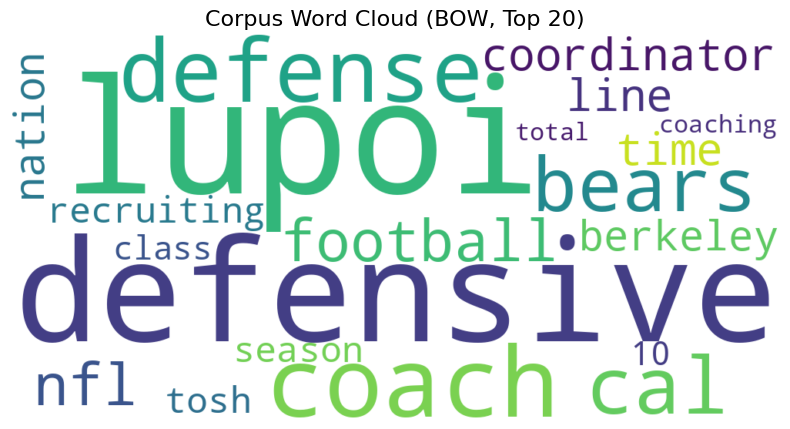

In [76]:
word_cloud(df, method="bow")


tfidf Matrix Shape (no. sentences x no. unique words in corpus):  (45, 351)


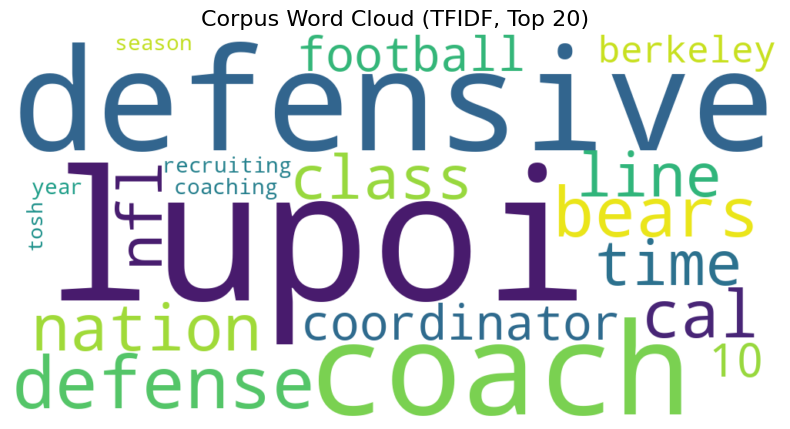

In [77]:
word_cloud(df, method="tfidf")

## Semantic Search

In [44]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"

def load_embedding_model(model_name):

    model = SentenceTransformer(model_name)
    
    modules = list(model._modules.keys())
    for key in modules:
        if model._modules[key].__class__.__name__ == "Normalize":
            del model._modules[key]

    return model


In [49]:
def embed_matrix(df, model_name, method = "cos", content_col = "sentence", batch_size=16):
    
    df = df.copy()
    chunks = df[content_col].astype(str).tolist()

    embed_model = load_embedding_model(model_name)
    embedding_dim = embed_model.get_sentence_embedding_dimension()
    print("Embedding dimension size per sentence/chunk (set by model):", embedding_dim)

    embed_matrix = embed_model.encode(
        chunks,
        batch_size=batch_size,
        normalize_embeddings=False,
        show_progress_bar=True
    ).astype("float32")
    print("Embedding Matrix Shape (no. sentences/chunks x model's embedding dimensions):", embed_matrix.shape)
    
    if method == 'cos':
        norms = np.linalg.norm(embed_matrix, axis=1, keepdims=True)
        embed_matrix = embed_matrix / norms
        df["embedding_cos"] = list(embed_matrix)

    elif method == 'dot':
        df["embedding_dot"] = list(embed_matrix)
        

    return df, embed_matrix

df_cos, cos_matrix = embed_matrix(df, model_name)
df_dot, dot_matrix = embed_matrix(df, model_name, method='dot')


Embedding dimension size per sentence/chunk (set by model): 384


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embedding Matrix Shape (no. sentences/chunks x model's embedding dimensions): (45, 384)
Embedding dimension size per sentence/chunk (set by model): 384


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embedding Matrix Shape (no. sentences/chunks x model's embedding dimensions): (45, 384)


In [73]:
def semantic_search(user_query, method="cos", knn=5):
    
    start = time.perf_counter()

    embed_model = load_embedding_model(model_name)
    q_raw = embed_model.encode(
        [user_query],
        normalize_embeddings=False,
        show_progress_bar=False
    ).astype("float32")[0]  # (embedding_dim,)

    if method == "cos":
        # Cosine search expects L2-normalized vectors
        q_norm = np.linalg.norm(q_raw)
        q_emb = q_raw / max(q_norm, 1e-12)

        sims_all = (cos_matrix @ q_emb).astype("float32")          
        dists_all = (1.0 - sims_all).astype("float32")             
        top_idx = np.argsort(-sims_all)[:knn]
        top_scores_raw = sims_all[top_idx]

    elif method == "dot":
        sims_all = (dot_matrix @ q_raw).astype("float32")           
        top_idx = np.argsort(-sims_all)[:knn]
        top_scores_raw = sims_all[top_idx]

    else:
        raise ValueError("method must be 'cos' or 'dot'")


    sims_arr = sims_all.reshape(-1, 1)
    if float(sims_arr.std()) == 0.0:
        sims_scaled_all = np.zeros_like(sims_arr, dtype="float32").ravel()
    else:
        sims_scaled_all = StandardScaler().fit_transform(sims_arr).astype("float32").ravel()

    top_scores_scaled = sims_scaled_all[top_idx]

    latency_ms = round((time.perf_counter() - start) * 1000.0, 1)

    results_df = pd.DataFrame({
        "sentence_id": df.iloc[top_idx]["id"].values,
        "sentence": df.iloc[top_idx]["sentence"].values,
        "rank": np.arange(1, len(top_idx) + 1),
        "score_scaled": top_scores_scaled.astype("float32"),
        "method": method,
        "latency_ms": latency_ms,
    })

    return results_df


## Keyword Search
- TF-IDF
- BM25: "Best matching" i.e. TFIDF but normalises for long sentences/corpus

In [63]:
def tf_idf_matrix(df, corpus_col):
    print(df.shape)
    corpus = df[corpus_col].astype(str).tolist()
    vectorizer= TfidfVectorizer(stop_words="english")
    matrix = vectorizer.fit_transform(corpus)
    print(matrix.shape)
    return matrix, vectorizer

tfidf_matrix, tfidf_vectorizer = tf_idf_matrix(df, "sentence")

(45, 4)
(45, 351)


In [70]:
def tfidf_search(query, df, k: int = 5):
    start = time.perf_counter()
    
    #Vectorise Query
    query_vector = tfidf_vectorizer.transform([str(query)])
    
    scores = (query_vector @ tfidf_matrix.T).toarray().ravel().astype("float32")

    scores_arr = scores.reshape(-1, 1)
    if scores_arr.std() == 0:
        scores_scaled = np.zeros_like(scores_arr).ravel()
    else:
        scores_scaled = StandardScaler().fit_transform(scores_arr).ravel()

    top_idx = np.argsort(-scores)[:k]
    latency_ms = round((time.perf_counter() - start) * 1000, 1)

    rows = []
    for rank, idx in enumerate(top_idx, start=1):
        rows.append({
            "sentence_id": df.iloc[idx]["id"],
            "sentence": df.iloc[idx]["sentence"],
            "rank": int(rank),
            "score_scaled": float(scores_scaled[idx]),
            "method": "tfidf",
            "latency_ms": float(latency_ms),
        })

    return pd.DataFrame(rows)



In [60]:
def build_bm25(df, corpus_col):
    print(df.shape)
    corpus = df[corpus_col].astype(str).tolist()
    
    corpus_tokens = bm25s.tokenize(corpus, stopwords='english')
    bm25_algo = bm25s.BM25()
    bm25_algo.index(corpus_tokens)
    return bm25_algo

bm25_matrix = build_bm25(df, "sentence")



(45, 4)


Split strings:   0%|          | 0/45 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/45 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/45 [00:00<?, ?it/s]

In [69]:
def bm25_search(query, df, k=5):
    
    start = time.perf_counter()

    # tokenize query
    query_tokens = bm25s.tokenize([query], stopwords='english')

    doc_ids, scores = bm25_matrix.retrieve(query_tokens, k=k)

    latency_ms = round((time.perf_counter() - start) * 1000, 1)

    doc_ids = np.asarray(doc_ids)[0]
    scores = np.asarray(scores)[0].astype("float32")

    # scale scores
    scores_arr = scores.reshape(-1, 1)
    if scores_arr.std() == 0:
        scores_scaled = np.zeros_like(scores_arr).flatten()
    else:
        scores_scaled = StandardScaler().fit_transform(scores_arr).flatten()

    records = []
    for rank, (idx, score_scaled) in enumerate(zip(doc_ids, scores_scaled), start=1):
        idx = int(idx)
        records.append({
            "sentence_id": df.iloc[idx]["id"],
            "sentence": df.iloc[idx]["sentence"],
            "rank": int(rank),
            "score_scaled": float(score_scaled),   
            "method": "bm25",
            "latency_ms": float(latency_ms),
        })

    return pd.DataFrame(records)



# Query

In [52]:
class UserInput(BaseModel):
    query: str = Field(min_length=10)


In [326]:
query_test = "hi, can"

print(query_test)
try:
    UserInput(query=query_test)
except ValidationError as e:
    print(e)

hi, can
1 validation error for UserInput
query
  String should have at least 10 characters [type=string_too_short, input_value='hi, can', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/string_too_short


query = "Did Tosh Lupoi ever coach a bird?"
query = "Did Tosh Lupoi ever coach in Georgia?"
query = "Has he been to Atlanta?"
query = "Did Tosh Lupoi ever coach in Atlanta?"
query = "Has he ever coached in Atlanta?"
query = "coach of atlanta falcons"
query = "has he coached with the Atlanta Falcons"

Answer can be found in sentence_id = [3, 26, 27]
4 = Lupoi has additionally spent time on the coaching staff at the University of Washington and in the NFL with the Cleveland Browns, **Atlanta Falcons** and Jacksonville Jaguars.
27 = Prior to his one-year stint with the Jaguars, Lupoi served as the defensive line coach and run game coordinator in **Atlanta**.
28 = During his time with the Falcons, **Atlanta** allowed the sixth-fewest rushing yards in the NFL (1,677) and tied for seventh-fewest first downs on the ground (97)


### Query Decomposition
- Using NER/POS to identify keywords such as nouns to assist keyword searches

In [50]:
def decompose_query(query):

    words = word_tokenize(query)

    pos_tags = pos_tag(words)

    pos_prefix = ("NN")

    filtered_words = [word for word, tag in pos_tags if tag.startswith(pos_prefix)]

    pos_query = " ".join(filtered_words)
    
    return query, pos_query


Answer can be found in sentence_id = [4, 27, 28]

**Keyword Search Strength**
raw_query = "did Tosh Lupoi coach with the Atlanta Falcons" --> perfect TFIDF/BM25

**Comparable**
raw_query = "Do you know if Lupoi ever been to the great city of Atlanta?"
- Keyword retriever's outperform when pos_query turned on

**Semantic Search Strength 2/3 Cosine, 0 from Keyword retrievers**
raw_query = "Do you know if Lupoi ever coached for a team named after a bird!"
raw_query = "Do you know if Lupoi ever been to the great city of Atalanta?"
raw_query = "Do you know if Lupoi ever coached in a state near Florida?"

In [ ]:
raw_query = "did Tosh Lupoi coach with the Atlanta Falcons"

try:
    UserInput(query=raw_query)
except ValidationError as e:
    print(e)

query, pos_query = decompose_query(raw_query)


# Example usage:


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

In [78]:
test_cos = semantic_search(query, method="cos", knn=3)
test_dot = semantic_search(query, method="dot", knn=3)
test_bm25 = bm25_search(query, df, k=3)
test_tfidf = tfidf_search(query, df, k=3)
test_results = pd.concat([test_cos, test_dot,test_bm25, test_tfidf], ignore_index=True)
test_results["correct"] = (test_results["sentence_id"].isin([4, 27, 28]).map({True: "Correct", False: "-"}))

test_results

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

,sentence_id,sentence,rank,score_scaled,method,latency_ms,correct
0,27,"Prior to his one-year stint with the Jaguars, ...",1,1.848253,cos,3198.4,Correct
1,1,"Tosh Lupoi, a former California defensive line...",2,1.603893,cos,3198.4,-
2,15,I look forward to partnering with Ron and Tosh...,3,1.551220,cos,3198.4,-
3,27,"Prior to his one-year stint with the Jaguars, ...",1,2.288812,dot,3195.0,Correct
4,42,"As a player, Lupoi was a defensive lineman for...",2,2.203534,dot,3195.0,-
5,31,Lupoi accepted his first coaching job outside ...,3,1.431506,dot,3195.0,-
6,4,Lupoi has additionally spent time on the coach...,1,1.412544,bm25,7.7,Correct
7,27,"Prior to his one-year stint with the Jaguars, ...",2,-0.646782,bm25,7.7,Correct
8,28,"During his time with the Falcons, Atlanta allo...",3,-0.765762,bm25,7.7,Correct
9,4,Lupoi has additionally spent time on the coach...,1,3.469277,tfidf,0.9,Correct


In [79]:
raw_query = "Do you know if Lupoi ever coached for a team named after a bird!"

try:
    UserInput(query=raw_query)
except ValidationError as e:
    print(e)

query, pos_query = decompose_query(raw_query)

test_cos = semantic_search(query, method="cos", knn=3)
test_dot = semantic_search(query, method="dot", knn=3)
test_bm25 = bm25_search(query, df, k=3)
test_tfidf = tfidf_search(query, df, k=3)
test_results = pd.concat([test_cos, test_dot,test_bm25, test_tfidf], ignore_index=True)
test_results["correct"] = (test_results["sentence_id"].isin([4, 27, 28]).map({True: "Correct", False: "-"}))

test_results

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

,sentence_id,sentence,rank,score_scaled,method,latency_ms,correct
0,4,Lupoi has additionally spent time on the coach...,1,1.831036,cos,3103.6,Correct
1,27,"Prior to his one-year stint with the Jaguars, ...",2,1.699978,cos,3103.6,Correct
2,25,"It's time!"" While in the NFL, Lupoi worked wit...",3,1.565286,cos,3103.6,-
3,42,"As a player, Lupoi was a defensive lineman for...",1,2.380445,dot,3088.1,-
4,27,"Prior to his one-year stint with the Jaguars, ...",2,2.120332,dot,3088.1,Correct
5,31,Lupoi accepted his first coaching job outside ...,3,1.660613,dot,3088.1,-
6,15,I look forward to partnering with Ron and Tosh...,1,1.089084,bm25,7.5,-
7,40,Lupoi was named the 2010 Rivals Recruiter of t...,2,0.236753,bm25,7.5,-
8,2,Lupoi comes home to Berkeley to become the 35t...,3,-1.325837,bm25,7.5,-
9,15,I look forward to partnering with Ron and Tosh...,1,3.282268,tfidf,1.0,-
